In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import correlate as im_corr
from scipy.stats import poisson
plt.rcParams['font.size'] = 15
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10

### Useful function definitions

In [2]:
from numpy.lib import stride_tricks

# Useful functions
H = lambda x: -np.sum(x[x>0]*np.log2(x[x>0]))

def add_fake_dimension(org_ndarray, win_size):
    """ Rolls a window over a vector and extracts the content within the window
    Stride_tricks only affect the shape and strides in the array interface.
    The memory footprint is therefore equal for both org_ndarray and
    fake_ndarray.
    Important!!!
    The windowed dimension in X must be along the first dimension (axis=0)
    Args:
        org_ndarray: vector to roll the window over
        win_size: window size in vector elements
    Returns:
        fake_ndarray:
    Raises:
    """
    n_element = org_ndarray.size
    element_size = org_ndarray.itemsize
    input_dims = org_ndarray.shape
    stride_length = 1
    for dims in input_dims[1:]:
        stride_length *= dims

    org_1darray = org_ndarray.ravel()

    shape = (n_element/stride_length - win_size + 1, win_size*stride_length)
    strides = (stride_length*element_size, element_size)
    fake_2darray = stride_tricks.as_strided(org_1darray, shape=shape, strides=strides)

    new_shape = [shape[0], win_size]
    for dims in input_dims[1:]:
        new_shape.append(dims)

    fake_ndarray = fake_2darray.reshape(new_shape)
    return fake_ndarray

def getBiasCorrection(words):
    """ Returns a bias corrected entropy
    See Part 2, entropy and bias correction
    Args:
        words: 2D array of code words with each row representing one word
    Returns:
        biasCorrectedEntropy:
    Raises:
    """
    nReps = 5
    nSamples, wordLength = words.shape
    fracs = np.logspace(np.log10(0.25), np.log10(1), 5)
    entropies = []
    for frac in fracs:
        nSubSamples = np.int64(np.round(frac*nSamples))
        entropyTmp = 0
        for rep in range(nReps):
            permutation = np.random.permutation(nSamples)
            uniqueWords, wordCounts = np.unique(words[permutation[0:nSubSamples], :], axis=0, return_counts=True)
            wordProb = wordCounts / np.float64(wordCounts.sum())
            entropyTmp += H(wordProb)
        entropies.append(entropyTmp/nReps)
        
    # Quadratic fit
    A = np.vstack([np.ones(fracs.size), 1./fracs, 1./fracs**2])
    w = np.linalg.lstsq(A.T, entropies)[0]
    correction =  -w[1:].sum()
    return correction

def getValidEntropies(entropies, biasCorrections, threshold=0.02):
    """ Returns valid entropy estimates
    Check which entropies that are valid based on the size of the correction
    Args:
        entropies: raw entropy estiamtes
        biasCorrections: bias corrections
        threshold: threshold fraction for determining valid entropies
    Returns:
        validEntropies: boolean array with valid entries
    Raises:
    """
    return biasCorrections/entropies < threshold
    
    
def getInfiteLengthExtrapolation(entropies, biasCorrections, wordLengths, nIgnore=0):
    """ Returns the extrapoalted entropy for an infinite word length
    Args:
        entropies: raw entropy estiamtes
        biasCorrections: bias corrections
        wordLengths:
        nIgnore: ignore the n smallest word lengths
    Returns:
        A: linear regression matrix
        w: parameters for the linear extrapolation
    Raises:
    """
    validEntropies = getValidEntropies(entropies, biasCorrections)
    A = np.vstack([np.ones(validEntropies.sum()), 1./wordLengths[validEntropies]])
    b = (entropies+biasCorrections)[validEntropies]
    w = np.linalg.lstsq(A[:, nIgnore:].T, b[nIgnore:])[0]
    A = np.hstack([A, np.array([[1], [0]])])
    
    return A, w

### Quantifying the amount of information in a spike train

Neurons communicate through spikes and their spike trains thus convey information, but how much? The concepts of entropy and mutual information can easily be extended to answer this question, by focusing on entropy rates instead of just entropy. For example, if you obtain one hundred independent samples per second from a distribution with an entropy of 1 bit, then the entropy rate is 100 bits/s. 

Quantifying the information rates of spike trains thus relies on binning these into vectors of spike counts. The entropy rate is then defined as the entropy of the distribution from which the spike count vector is drawn divided by the duration of time over which the vector was obtained. In the simplest of cases, where no temporal correlations are present, it is enough to just look at the entropy of the one-dimensional distribution underlying the counts in each bin. However, if temporal correlations are present, then one needs to determine the entropy of the multidimensional distribution from which longer spike count vectors are drawn, as we will see further down.

### Entropy of Poisson spike trains (theoretical)

Initially, it is a good idea to first try to get an impression of how the firing rate and the binning width affect the entropy rate. To keep things simple, we assume that spikes are drawn from a Poisson distribution and that the spike count in each bin is independent. With these simplifications, the entropy rate is simply the entropy for a Poisson distribution divided by the bin width. As shown below, the entropy rate increases as a function of both the firing rate and the bin width. Thus indicating that a neurons ability to transmit information increases with higher firing rates and with a higher temporal precision.

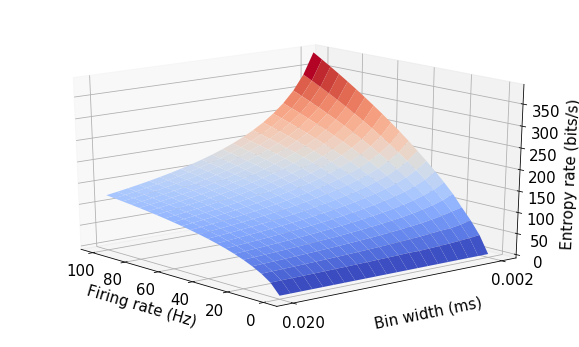

In [3]:
nVals = 21
firingRates = np.linspace(0, 100, nVals)           # spikes per second (Hz)
binWidths = np.linspace(0.002, 0.02, nVals)        # bin width (s)
firingRatesGrid, binWidthsGrid = np.meshgrid(firingRates, binWidths)

# Determine entropy rates 
entropyRates = np.zeros(firingRatesGrid.shape)
for i, rate, width in zip(np.arange(nVals*nVals), firingRatesGrid.ravel(), binWidthsGrid.ravel()):
    muRate = rate*width                            # Mean count within each bin corresponding to the mean firing rate
    maxVal = muRate + 10*np.sqrt(muRate)           # Upper count limit after which the probability is essentially zero
    p = poisson.pmf(np.arange(maxVal), muRate)
    entropyRates.ravel()[i] = H(p)/width

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(firingRatesGrid, binWidthsGrid, entropyRates, cmap=coolwarm)
ax.set_xticks(np.linspace(0, 100, 6))
ax.set_xlabel('Firing rate (Hz)', labelpad=10)
ax.set_yticks(np.linspace(0.002, 0.02, 2))
ax.set_ylabel('Bin width (ms)', labelpad=10)
ax.set_zlabel('Entropy rate (bits/s)', labelpad=5)
ax.view_init(20, 140)

### Entropy of Poisson spike trains (empirical)

Real spike trains obviously contain some temporal correlations. We therefore need a method for extracting entropy rates that corrects for any such temporal correlations. Strong et al. (1998) presented such a method for neural spike trains and this method appears to have been used in essentially all studies since. The basic idea is to determine entropy rates for spike count vectors (also called words) of increasing length, and then correct for temporal correlations by extrapolating to an infinite word length. To begin with, we will skip the extrapolation step and instead just familiarize us with the method by looking at its output for the same independent Poisson case as above, but with fixed firing rate and bin width. In short, we will generate a long vector of spike counts and subsequently try to empirically estimate the entropy of the probability distributions for words of varying length.

Theoretical entropy: 99.71


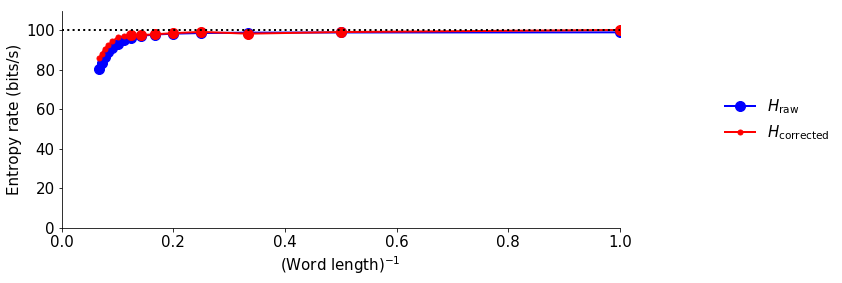

In [4]:
# Parameters
rate = 30
width = 0.01
nSamples = 10000;
wordLengths = np.arange(1, 16);

# Get the theoretical entropy rate
muRate = rate*width                            # Mean count within each bin corresponding to the mean firing rate
maxVal = muRate + 10*np.sqrt(muRate)           # Upper count limit after which the probability is essentially zero
p = poisson.pmf(np.arange(maxVal), muRate)
theoreticalEntropy = H(p)/width

# Generate a sequence of Poisson data
r = np.random.poisson(np.ones(nSamples)*rate*width)

# Calculate raw and bias corrected entropies for all word lengths
entropies = np.zeros(wordLengths.size)
biasCorrections = np.zeros(wordLengths.size)
for i, wordLength in enumerate(wordLengths):
    words = add_fake_dimension(r, wordLength)
    uniqueWords, wordCounts = np.unique(words, axis=0, return_counts=True)
    wordProb = wordCounts / np.float64(wordCounts.sum())
    entropies[i]= H(wordProb)/width/wordLength
    biasCorrections[i] = getBiasCorrection(words)/width/wordLength
validEntropies = getValidEntropies(entropies, biasCorrections, threshold=0.02)
    
print('Theoretical entropy: %2.2f') % theoreticalEntropy
    
# Plot empirical entropy rates as a function of word length
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(1./wordLengths, entropies, 'bo-', label='$H_\mathrm{raw}$')
ax.plot(1./wordLengths, entropies+biasCorrections, 'r.-', label='$H_\mathrm{corrected}$')
ax.plot(1./wordLengths[validEntropies], (entropies+biasCorrections)[validEntropies], 'ro')
ax.axhline(theoreticalEntropy, ls=':', color='k')
ax.set_ylim([0, 1.1*theoreticalEntropy])
ax.set_xlim([0, 1])
ax.set_xlabel('(Word length)$^{-1}$')
ax.set_ylabel('Entropy rate (bits/s)');
ax.legend(frameon=False, bbox_to_anchor=(1, 0, 0.4, 1), loc=5);

The main observation from the figure above is that the estimated entropy rate is essentially identical to the theoretical one for word lengths up to 6-7 bins. For longer words, finite sample effects start affecting our estimates, and the bias gets more severe as the word length increases (more and more data is needed when estimating entropies of higher dimensional distributions). The bias correction mechanism explained in Part 2 can alleviate the problem to some extent, but the improvement is quite modest (compare the red to the blue line above). However, the bias correction mechanism also provides us with a way of checking when finite sample effects start affecting our entropy estimates significantly. The larger red dots above, for example, denotes cases when the correction is predicted to be less than 2%, and thus sorts out the cases where we can reasonable sure that we have a good estimate.

In summary, we thus see that the entropy estimates for words of varying length are identical whenever no temporal correlations are present (as expected).

### Mutual information, noiseless transmission

Next, we will look at an example with temporal correlations. More precisely, we assume that a light sensitive cell is being stimulated by a binary stimulus sequence $\mathbf{x}$, where each element $x$ is drawn from a uniform binary distribution $X\sim U\{0, 1\}$. The cell performs a temporal summation over time and outputs $y_i=\mathbf{w}^T\mathbf{x}_i$ spikes in bin $i$, with $\mathbf{w}$ being a temporal filter and $\mathbf{x}_i$ the recent stimulus history up to time point $i$. We further assume that the output is deterministic, meaning that the noise entropy is zero and that the information rate (mutual information) simply equals the entropy rate.

Theoretical entropy: 100.00
Estiamted entropy: 99.97


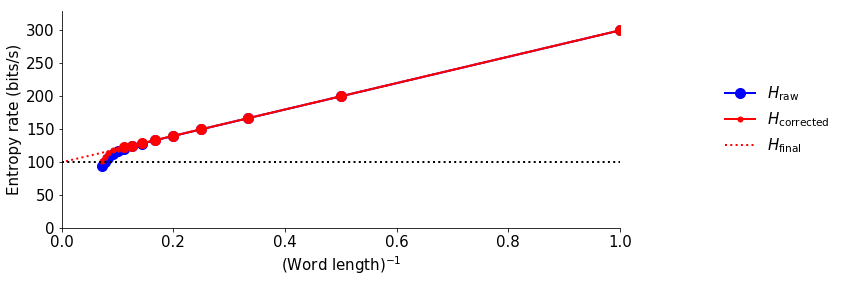

In [5]:
width = 0.01
nSamples = 10000
w = np.array([1, 2, 4])
wordLengths = np.arange(1, 15);

# Generate a random binary sequence and calculate the spike count in each bin
x = (np.sign(np.random.randn(nSamples))+1) / 2
y = im_corr(x, w, mode='constant', origin=(w.size-1)/2)

# Noiseless transmission ->  theoretical I same as the entropy of the binary stimulus x
theoreticalEntropy = 1./width

# Calculate raw and bias corrected entropies for various word lengths
entropies = np.zeros(wordLengths.size)
biasCorrections = np.zeros(wordLengths.size)
for i, wordLength in enumerate(wordLengths):
    words = add_fake_dimension(y, wordLength)
    uniqueWords, wordCounts = np.unique(words, axis=0, return_counts=True)
    wordProb = wordCounts / np.float64(wordCounts.sum())
    entropies[i]= H(wordProb)/width/wordLength
    biasCorrections[i] = getBiasCorrection(words)/width/wordLength
validEntropies = getValidEntropies(entropies, biasCorrections) 
A, w = getInfiteLengthExtrapolation(entropies, biasCorrections, wordLengths, nIgnore=2)

print('Theoretical entropy: %2.2f') % theoreticalEntropy
print('Estiamted entropy: %2.2f') % w[0]

# Plot entropies as a function of the word length
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(1./wordLengths, entropies, 'bo-', label='$H_\mathrm{raw}$')
ax.plot(1./wordLengths, entropies+biasCorrections, 'r.-', label='$H_\mathrm{corrected}$')
ax.plot(1./wordLengths[validEntropies], (entropies+biasCorrections)[validEntropies], 'ro')
ax.plot(A[1, :], np.dot(A.T, w), 'r:', label='$H_\mathrm{final}$')
ax.axhline(theoreticalEntropy, ls=':', color='k')
ax.set_ylim([0, 1.1*entropies.max()])
ax.set_xlim([0, 1])
ax.set_xlabel('(Word length)$^{-1}$')
ax.set_ylabel('Entropy rate (bits/s)');
ax.legend(frameon=False, bbox_to_anchor=(1, 0, 0.4, 1), loc=5);

In the example above, where $\mathbf{w}=[1, 2, 4]$, the cell outputs a unique spike count that directly identifies what the stimulus was during the preceding three time steps. However, this means that the value of $x_i$ can be revealed from either of $y_i$, $y_{i+1}$, or $y_{i+2}$, and that the spike output thus conveys the same information during multiple time steps (the output is correlated in time). We will consequently overestimate the entropy rate if we only look at words of length one (300 bits in the figure above), as this approach fails to take the correlations into account. However, if we look at the entropy rates for words of increasing length, we notice that they decrease and that they probably decrease to roughly 100 bits/s if you would extrapolate to an infinite word length. Thus, we see that our estimate of the entropy rate is only correct when extrapolated to an infinite word length, whenever temporal correlations are present. You might wonder whether this was just a coincidence, but Strong et al. (1998) highlight that the leading subextensive correction term is a constant whenever the correlations are of finite length. However, is you play around with different values of $\mathbf{w}$ above, you will notice that the extrapolation is not always this good, and that you might need a lot of data before the extrapolation works well.

### Mutual information, noisy transmission

In real life, the example cell above is obviously not deterministic. In such cases, we need to estimate both the entropy rate as well as the noise entropy rate. The latter can be obtained in the same manner as the former, with the only difference being that the probability distributions are conditioned on the stimulus. We thus need data where a stimulus sequence has been repeated hundreds of times so that the word distributions can be reliably estimated also for longer word lengths. These ideas are illustrated in the example below, where cell responses are modeled as above, but where noise (possibly correlated in time) is added to the spike counts.

Estiamted entropy: 200.36
Estiamted noise entropy: 100.03
Estiamted mutual information: 100.33


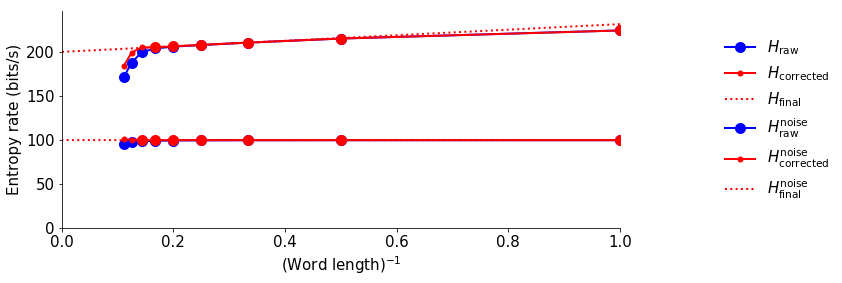

In [17]:
width = 0.01
nSamples = 50000
nNoiseSamples = 100
nNoiseReps = 1000
w = np.array([1, 2])
wn = np.array([1])
wordLengths = np.arange(1, 10);

# 1. Entropy first
# Generate a random binary sequence and calculate the spike count in each bin
x = np.random.randint(0, 2, nSamples);
y = im_corr(x, w, mode='constant', origin=(w.size-1)/2)
n = np.random.randint(0, 2, nSamples);
nc = im_corr(n, wn, mode='constant', origin=(wn.size-1)/2)
y += nc;

# Raw and bias corrected entropies for various word lengths
entropies = np.zeros(wordLengths.size)
biasCorrections = np.zeros(wordLengths.size)
for i, wordLength in enumerate(wordLengths):
    words = add_fake_dimension(y, wordLength)
    uniqueWords, wordCounts = np.unique(words, axis=0, return_counts=True)
    wordProb = wordCounts / np.float64(wordCounts.sum())
    entropies[i] = H(wordProb)/width/wordLength
    biasCorrections[i] = getBiasCorrection(words)/width/wordLength
validEntropies = getValidEntropies(entropies, biasCorrections) 
A, w = getInfiteLengthExtrapolation(entropies, biasCorrections, wordLengths, nIgnore=2)

print('Estiamted entropy: %2.2f') % w[0]

# 2. Noise entropy second
# Generate a shorter random binary sequence that is repeated many times, and calculate the spike count in each bin
x = np.random.randint(0, 2, nNoiseSamples);
yTmp = im_corr(x, w, mode='constant', origin=(w.size-1)/2)
n = np.random.randint(0, 2,[nNoiseSamples, nNoiseReps]);
nc = im_corr(n, np.reshape(wn, [wn.size, 1]), mode='constant', origin=(wn.size-1)/2)
yNoise = yTmp[:, np.newaxis] + nc

# Raw and bias corrected noise entropies for various word lengths
noiseEntropies = np.zeros(wordLengths.size)
noiseBiasCorrections = np.zeros(wordLengths.size)
for i, wordLength in enumerate(wordLengths):
    entropiesTmp = 0
    biasCorrectionsTmp = 0
    wordsAll = add_fake_dimension(yNoise, wordLength)
    for j in range(wordsAll.shape[0]):
        wordsTmp = wordsAll[j, :, :].T
        uniqueWords, wordCounts = np.unique(wordsTmp, axis=0, return_counts=True)
        wordProb = wordCounts / np.float64(wordCounts.sum())
        entropiesTmp += H(wordProb)/width/wordLength
        biasCorrectionsTmp += getBiasCorrection(wordsTmp)/width/wordLength
    noiseEntropies[i] = entropiesTmp / wordsAll.shape[0]
    noiseBiasCorrections[i] = biasCorrectionsTmp / wordsAll.shape[0]
validNoiseEntropies = getValidEntropies(noiseEntropies, noiseBiasCorrections) 
ANoise, wNoise = getInfiteLengthExtrapolation(noiseEntropies, noiseBiasCorrections, wordLengths, nIgnore=0)

print('Estiamted noise entropy: %2.2f') % wNoise[0]
print('Estiamted mutual information: %2.2f') % (w[0] - wNoise[0])

# Plot entropies as a function of word length
fig = plt.figure(figsize=(10, 4))
ax = plt.axes()
ax.plot(1./wordLengths, entropies, 'bo-', label='$H_\mathrm{raw}$')
ax.plot(1./wordLengths, entropies+biasCorrections, 'r.-', label='$H_\mathrm{corrected}$')
ax.plot(1./wordLengths[validEntropies], (entropies+biasCorrections)[validEntropies], 'ro')
ax.plot(A[1, :], np.dot(A.T, w), 'r:', label='$H_\mathrm{final}$')
ax.plot(1./wordLengths, noiseEntropies, 'bo-', label='$H_\mathrm{raw}^\mathrm{noise}$')
ax.plot(1./wordLengths, noiseEntropies+noiseBiasCorrections, 'r.-', label='$H_\mathrm{corrected}^\mathrm{noise}$')
ax.plot(1./wordLengths[validNoiseEntropies], (noiseEntropies+noiseBiasCorrections)[validNoiseEntropies], 'ro')
ax.plot(ANoise[1, :], np.dot(ANoise.T, wNoise), 'r:', label='$H_\mathrm{final}^\mathrm{noise}$')
ax.set_ylim([0, 1.1*entropies.max()])
ax.set_xlim([0, 1])
ax.set_xlabel('(Word length)$^{-1}$')
ax.set_ylabel('Entropy rate (bits/s)');
ax.legend(frameon=False, bbox_to_anchor=(1, 0, 0.4, 1), loc=5);